In [2]:
%cd /home/clay/userdata/BeatlikeMichael/transcription
%load_ext autoreload
%autoreload 2

/home/clay/userdata/BeatlikeMichael/transcription
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import torch
import torchaudio

import numpy as np
import librosa
import matplotlib.pyplot as plt

import pickle
from pathlib import Path
import IPython.display as ipd

from model_zoo import RNNModel_onset, RNNModel_velocity

## Load Models

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

onset_model = RNNModel_onset(num_nmels=128, hidden_size=128).to(device)
velocity_model = RNNModel_velocity(num_nmels=128, hidden_size=128).to(device)

# load model
onset_model.load_state_dict(torch.load('onset_model_noQZ.pt'))
velocity_model.load_state_dict(torch.load('velocity_model_noQZ.pt'))

<All keys matched successfully>

## Load audio samples

In [6]:
class SpecConverter():
  def __init__(self, sr=44100, n_fft=2048, hop_length=1024, n_mels=128, fmin=0, fmax=None):
    self.sr = sr
    self.n_fft = n_fft
    self.hop_length = hop_length
    self.n_mels = n_mels
    self.fmin = fmin
    self.fmax = fmax
  
  def forward(self, wav):
    mel_spec = torchaudio.transforms.MelSpectrogram(
      sample_rate=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels)
    log_mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec(wav))
    return log_mel_spec

spec_converter = SpecConverter(sr=44100, n_fft=512, hop_length=128, n_mels=128)


In [7]:
audio_path = Path('audio_samples/titi.wav')
sample_first, sr = torchaudio.load(audio_path)
ipd.Audio(sample_first.numpy(), rate=sr)

## Inference

In [8]:
mel_spec = spec_converter.forward(sample_first.unsqueeze(0))
mel_spec = mel_spec[0][0][:,:2756]
mel_spec = mel_spec.to(device)

threshold = 0.4
onset_pred = onset_model(mel_spec.unsqueeze(0))
onset_pred_guide = (onset_pred > threshold).float() # time x 4
velocity_pred = velocity_model(mel_spec.unsqueeze(0), onset_pred_guide.unsqueeze(0))
velocity_pred = velocity_pred * onset_pred_guide.unsqueeze(0)

/home/lifefeel/workspace/DNN_Music/transcription/venv/lib/python3.8/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


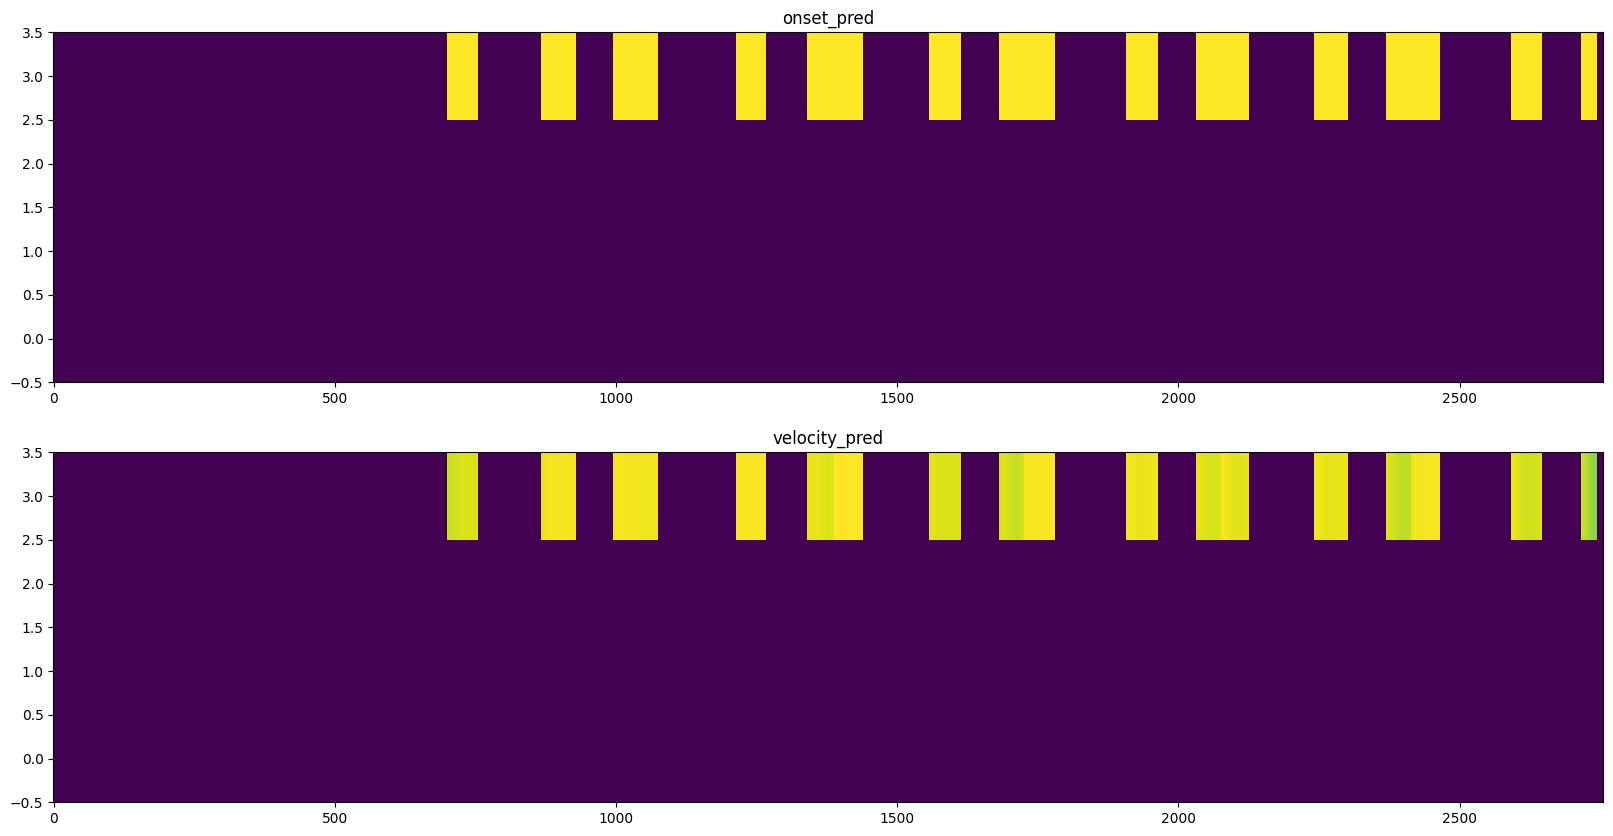

In [9]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.title('onset_pred')
plt.imshow(onset_pred_guide.squeeze().cpu().detach().numpy().T, aspect='auto', origin='lower', interpolation='nearest')
plt.subplot(2,1,2)
plt.title('velocity_pred')
plt.imshow(velocity_pred.squeeze().cpu().detach().numpy().T, aspect='auto', origin='lower', interpolation='nearest')

## Cleaning with High Frequency Content(HFC)

In [10]:
def high_freq_content(spectrogram_dB):
  # Convert the decibel values back to linear amplitude values
  spectrogram = librosa.db_to_power(spectrogram_dB)

  # Create a frequency axis
  freqs = librosa.core.mel_frequencies(n_mels=128)

  # Calculate the weighted mean of the amplitude for each bin
  hfc_values = np.empty(spectrogram.shape[1])
  for t in range(spectrogram.shape[1]):
    hfc_t = np.sum(freqs * spectrogram[:, t])
    hfc_values[t] = hfc_t

  return hfc_values

In [11]:
hfc_values = high_freq_content(mel_spec.cpu().detach().numpy())

In [12]:
onset_idx = np.argwhere(hfc_values > np.percentile(hfc_values, 60))
onset_pred_cleaned = torch.zeros_like(velocity_pred.squeeze())
for idx in onset_idx.squeeze():
  onset_pred_cleaned[idx] = velocity_pred.squeeze()[idx]

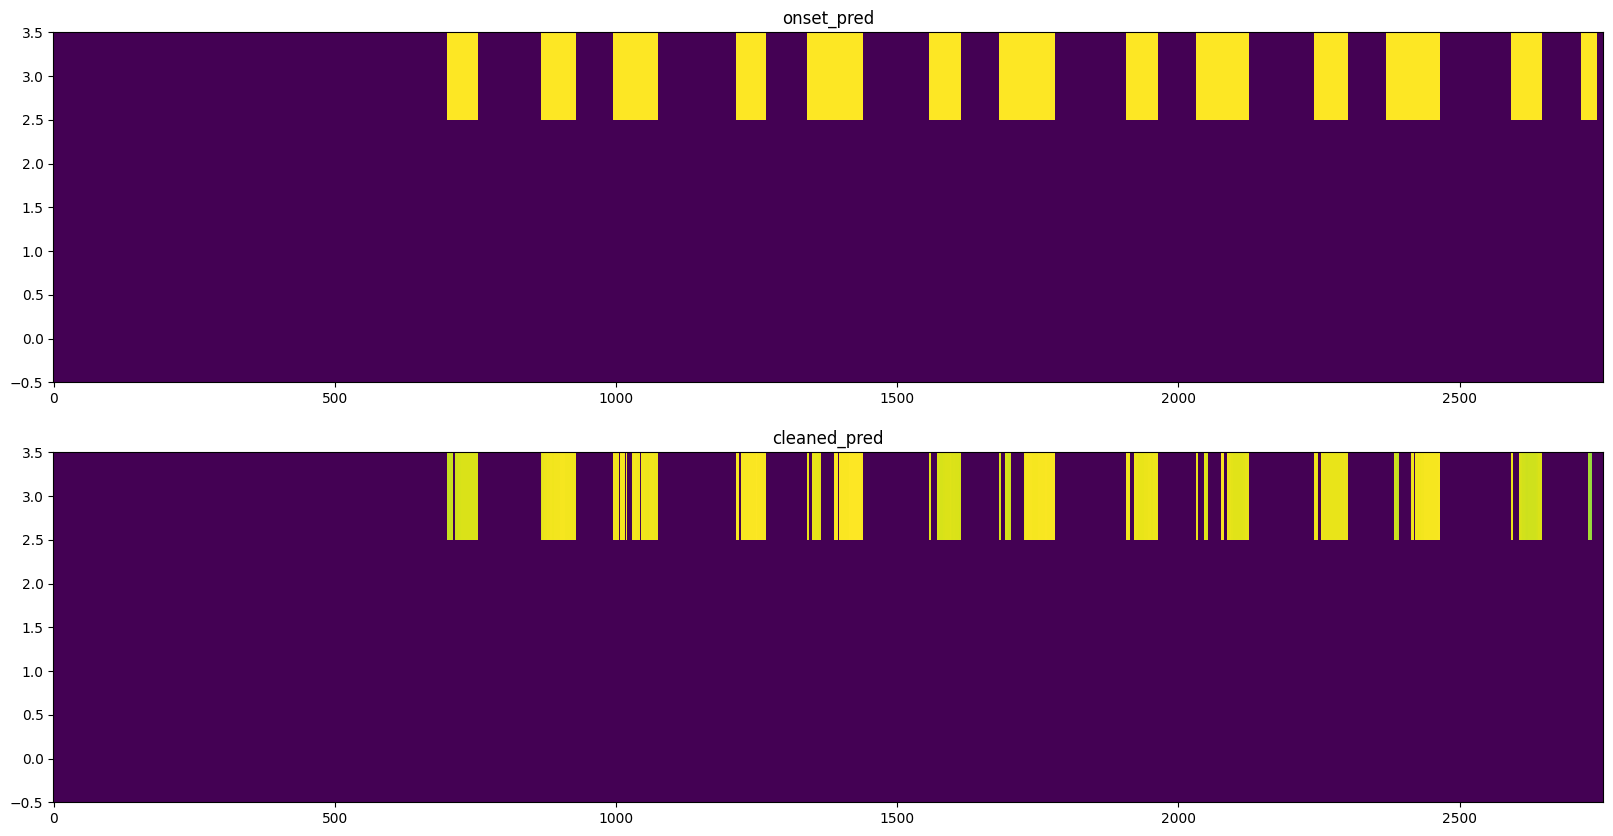

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.title('onset_pred')
plt.imshow(onset_pred_guide.squeeze().cpu().detach().numpy().T, aspect='auto', origin='lower', interpolation='nearest')
plt.subplot(2,1,2)
plt.title('cleaned_pred')
plt.imshow(onset_pred_cleaned.squeeze().cpu().detach().numpy().T, aspect='auto', origin='lower', interpolation='nearest')

## Quantization

In [14]:
def reducing_time_resolution(mel_spec, aggregate_factor=4, len_quantized=16):
  db_mel_spec_cnvtd = []
  for idx in range(len_quantized):
    spec_for_agg = mel_spec[:, idx*aggregate_factor:(idx+1)*aggregate_factor]
    aggregated_spec = torch.mean(spec_for_agg, dim=1, keepdim=True)
    #print(aggregated_spec[0].shape)
    db_mel_spec_cnvtd.append(aggregated_spec)
  db_mel_spec_cnvtd = torch.cat(db_mel_spec_cnvtd, dim=1)
  return db_mel_spec_cnvtd

#set 64 frame in db_mel_spec_cnvtd
# shape of onset_pred_cleaned: 2756 x 4
aggregate_factor = onset_pred_cleaned.shape[0] // 128
db_mel_spec_cnvtd = reducing_time_resolution(onset_pred_cleaned.T, aggregate_factor, 128) # 128 x timestep

In [15]:
threshold_idx = torch.argwhere(db_mel_spec_cnvtd > 0.3)
drum_roll_QZ = torch.zeros_like(db_mel_spec_cnvtd)
for row in threshold_idx:
  drum_roll_QZ[row[0], row[1]] = db_mel_spec_cnvtd[row[0], row[1]]

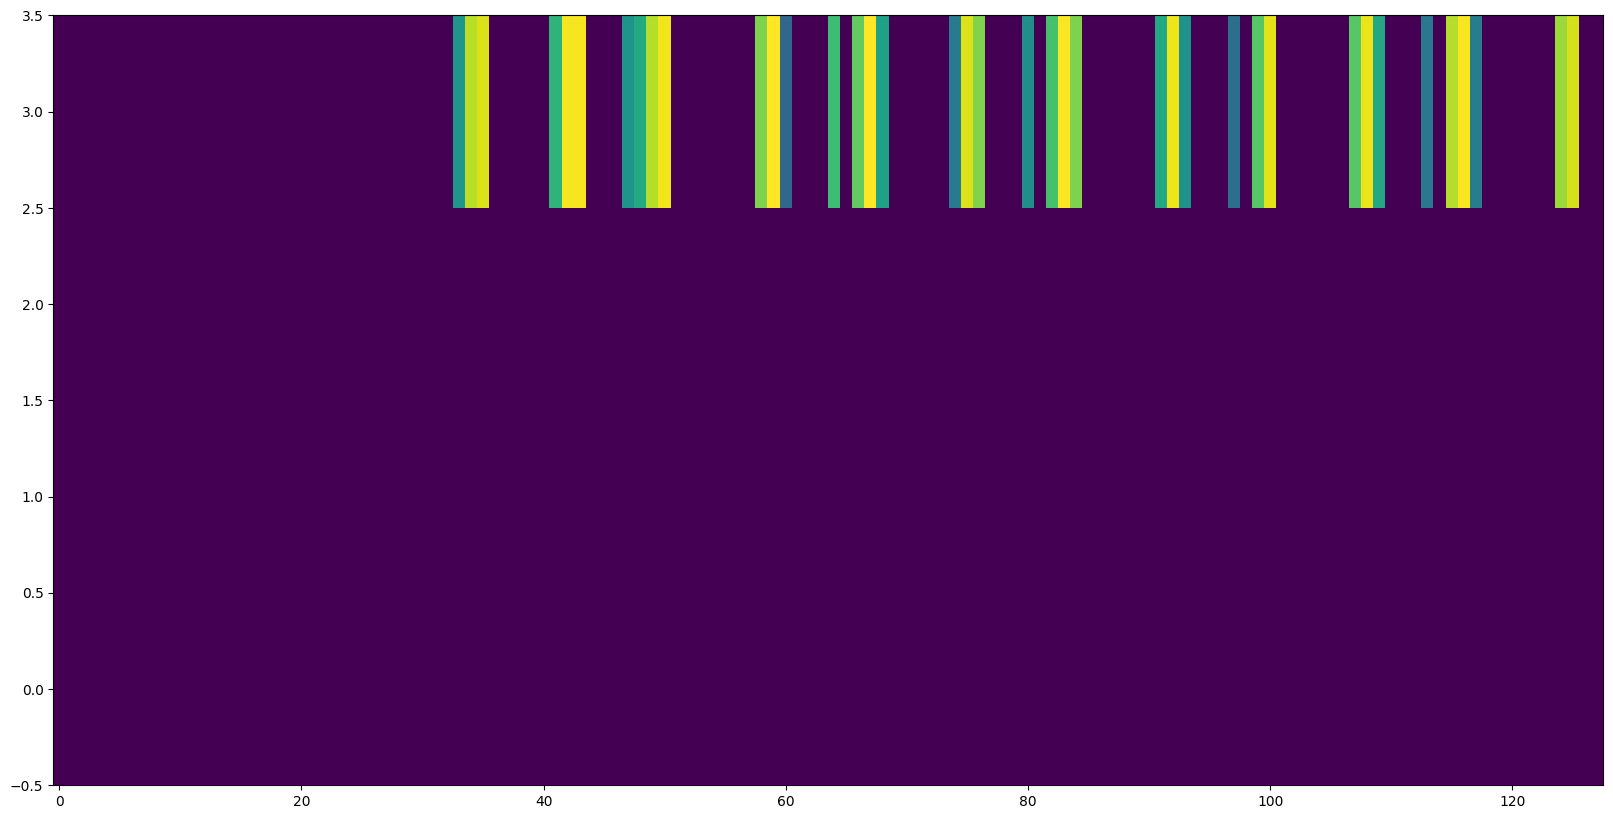

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(drum_roll_QZ.cpu().detach().numpy(), aspect='auto', origin='lower')

## Denoising

In [17]:
# find the first onset time
def denoise(drum_roll):
  first_onset_count = 90
  for row in drum_roll:
    for idx, val in enumerate(row):
      if val > 0:
        if first_onset_count - idx > 0:
          first_onset_count = idx
          break
      elif first_onset_count - idx < 0:
        break
  
  return drum_roll[:, first_onset_count:]
        

In [18]:
denoised_drum_roll = denoise(drum_roll_QZ)

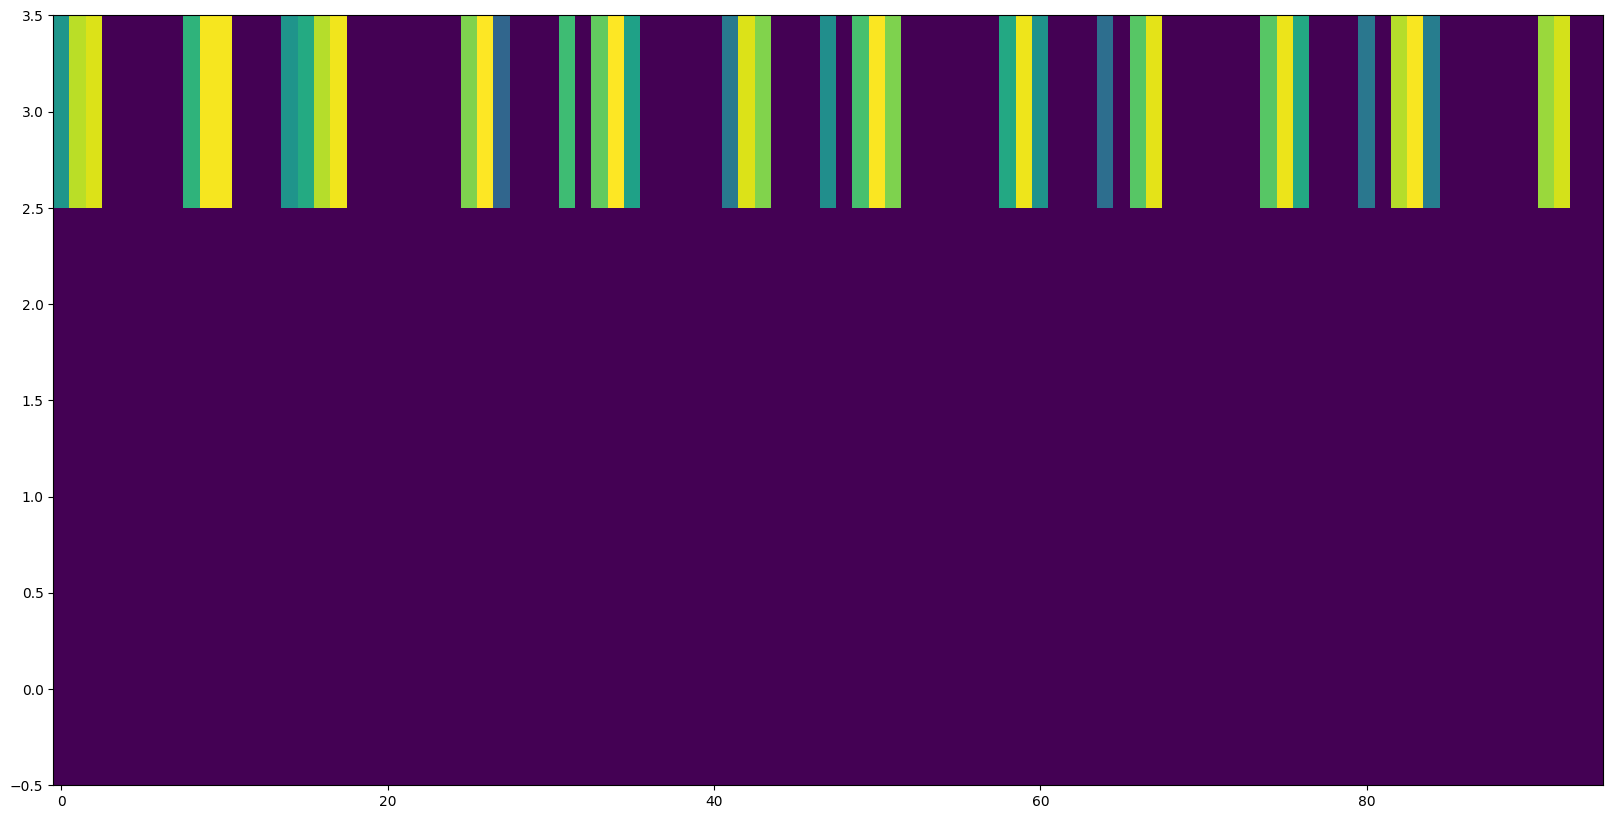

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(denoised_drum_roll.cpu().detach().numpy(), aspect='auto', origin='lower')

## Dense onsets

In [20]:
def Dense_onsets(tensor):
  result = np.zeros_like(tensor)
  avg = 0
  count = 0
  first_non_zero_index = None

  for i, value in enumerate(tensor):
    if value != 0:
      if first_non_zero_index is None:
        first_non_zero_index = i
      avg += value
      count += 1
    else:
        if count != 0:
          result[first_non_zero_index] = avg / count
          avg, count, first_non_zero_index = 0, 0, None
  if count != 0:
    result[first_non_zero_index] = avg / count

  return result

In [21]:
densed_drumroll = np.zeros_like(denoised_drum_roll.cpu().detach().numpy())
for idx, row in enumerate(denoised_drum_roll.cpu().detach().numpy()):
  densed_drumroll[idx] = Dense_onsets(row)

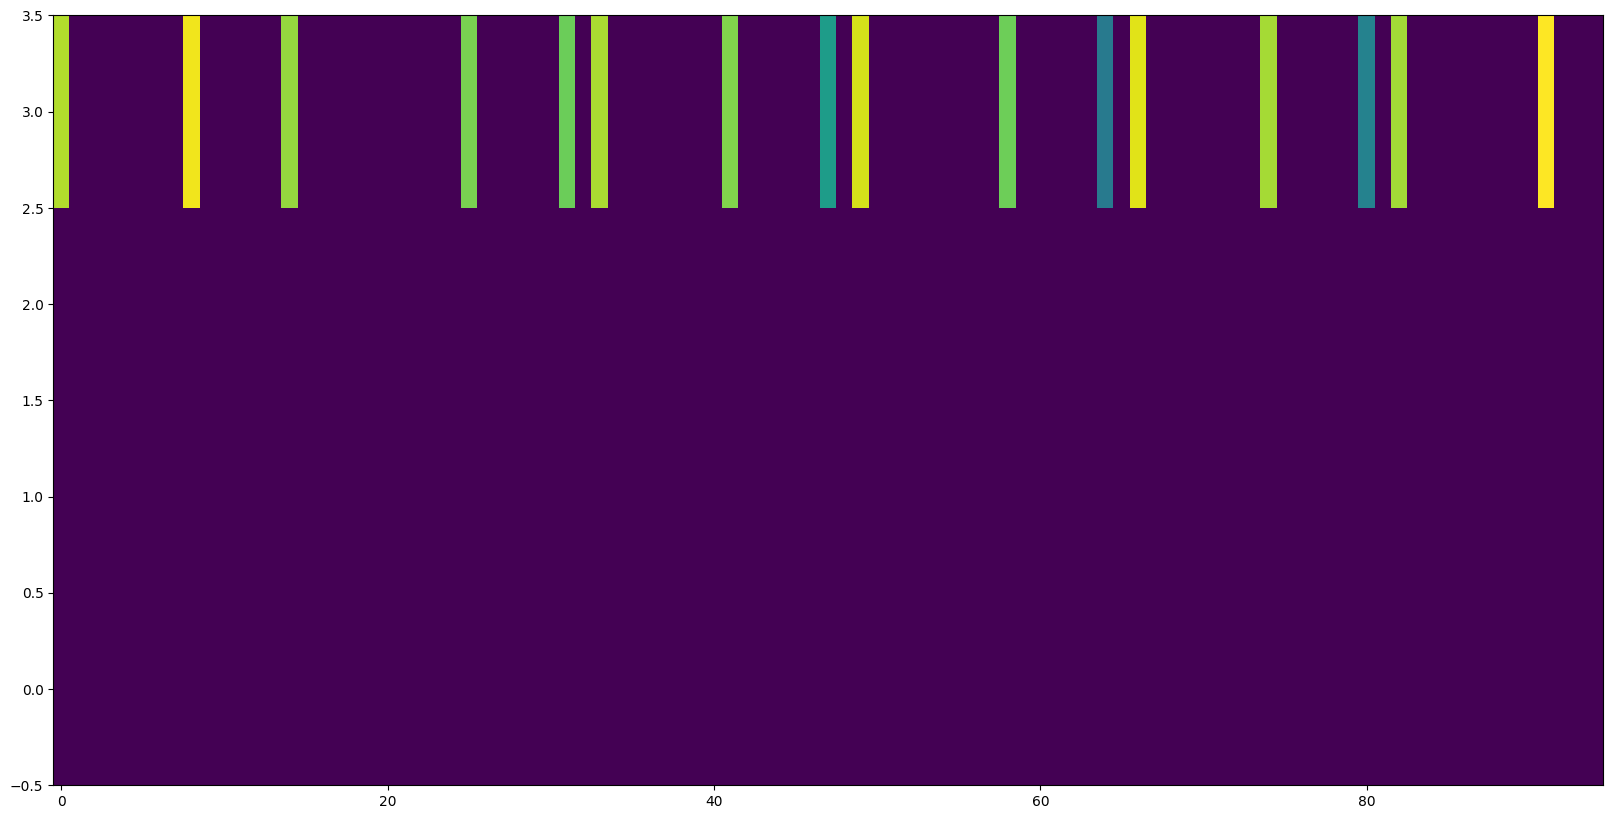

In [22]:
plt.figure(figsize=(20,10))
plt.imshow(densed_drumroll, aspect='auto', origin='lower')

## save results with pickle

In [102]:
audio_path.stem

'pmtati'

In [107]:
with open(f'transcribed_sample_results/{audio_path.stem}.pkl', 'wb') as f:
  pickle.dump(densed_drumroll[:,:64], f)

In [106]:
densed_drumroll[:,:64].shape

(4, 64)